In [1]:
import numpy as np
import random
from tqdm import tqdm

In [2]:
raw_data = np.loadtxt('./data/ml-100k/u.data', delimiter='\t')
raw_data = raw_data[:, :3].astype(int)

# Define model

In [3]:
import tensorflow as tf

In [4]:
sess = tf.InteractiveSession()

In [5]:
N_USERS = max(raw_data[:, 0]) + 1
N_ITEMS = max(raw_data[:, 1]) + 1
N_HIDDEN = 10

In [6]:
# placeholders
user_ids  = tf.placeholder(tf.int32, (None,), name='user_ids')
left_ids  = tf.placeholder(tf.int32, (None,), name='left_ids')
right_ids = tf.placeholder(tf.int32, (None,), name='right_ids')
target_y  = tf.placeholder(tf.float32, (None,), name='target_y')
alpha_reg = .5

# main parameters
user_latents = tf.Variable(tf.random_uniform(shape=(N_USERS, N_HIDDEN)), trainable=True, name='user_latents')
item_latents = tf.Variable(tf.random_uniform(shape=(N_ITEMS, N_HIDDEN)), trainable=True, name='item_latents')

## define batch processing

# get embeddings for batch
embedding_user  = tf.nn.embedding_lookup(user_latents, user_ids, name='embedding_user')
embedding_left  = tf.nn.embedding_lookup(item_latents, left_ids, name='embedding_left')
embedding_right = tf.nn.embedding_lookup(item_latents, right_ids, name='embedding_right')

# raw margins for primal ranking loss
embedding_diff = embedding_left - embedding_right

# shape: [n_batch, ]
embedding_margins = tf.reduce_sum(tf.mul(embedding_user, embedding_diff), axis=1, name='embedding_margins')

In [7]:
init_vars = tf.global_variables_initializer()
sess.run(init_vars)

In [8]:
import tensorflow.contrib.slim as slim
def network(user_emb, item_emb):
    joined_input = tf.concat(1, [user_emb, item_emb])
    net = slim.fully_connected(inputs=joined_input, num_outputs=64, activation_fn=tf.nn.relu)
    net = slim.fully_connected(inputs=net, num_outputs=32, activation_fn=tf.nn.relu)
    net = slim.fully_connected(inputs=net, num_outputs=16, activation_fn=tf.nn.relu)
    net = slim.fully_connected(inputs=net, num_outputs=1, activation_fn=None)
    return net

def mean_logloss(raw_margins, target_values, tag):
    # -y*f(x)
    myfx = -1*tf.mul(target_values, raw_margins)
    elementwise_logloss = tf.minimum(tf.log(1 + tf.exp(myfx)), 100, name='elwise_' + tag)
    mean_loss = tf.reduce_mean(elementwise_logloss, name='mean_' + tag)
    return mean_loss



# apply shared net
with tf.variable_scope("nn"):
    left_output = network(embedding_user, embedding_left)
with tf.variable_scope("nn", reuse=True):
    right_output = network(embedding_user, embedding_right)

# margins for net output
net_margins = left_output - right_output

# shape: [n_batch, 1] -> [n_batch, ]
net_margins = tf.squeeze(net_margins, axis=1, name='net_margins')

In [9]:
# losses
embedding_loss = mean_logloss(embedding_margins, target_y, 'embedding_loss')
net_loss = mean_logloss(net_margins, target_y, 'net_loss')

target = alpha_reg * embedding_loss + (1 - alpha_reg) * net_loss

In [10]:
# minimizers

In [11]:
trainer_3 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(target)
trainer_4 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(target)

In [12]:
# init vars

In [13]:
init_vars = tf.global_variables_initializer()
sess.run(init_vars)

# reassemble data

In [14]:
class TriplesDataset(object):
    def __init__(self, raw_data):
        self.data = {}
        for row in raw_data:
            u, i, r = row
            user_dict = self.data.get(u, {})
            rating_list = user_dict.get(r, [])
            rating_list.append(i)
            user_dict[r] = rating_list
            self.data[u] = user_dict
        self.data_keys = list(self.data.keys())
    
    def generate_triple(self):
        user = random.choice(self.data_keys)
        stats = self.data[user]
        stats_keys = list(stats.keys())
        assert(len(stats_keys) > 1)
        left_rating, right_rating = random.sample(stats_keys, 2)
        left_value = random.choice(stats[left_rating])
        right_value = random.choice(stats[right_rating])
        y = (left_rating > right_rating)*2 - 1
        return (user, left_value, right_value, y)
    
    def generate_batch(self, batch_size):
        retval = []
        for _ in range(batch_size):
            retval.append(self.generate_triple())
        retval = np.array(retval)
        return {
            'users': retval[:, 0].astype(np.int32), 
            'left_items': retval[:, 1].astype(np.int32),
            'right_items': retval[:, 2].astype(np.int32),
            'y': retval[:, 3].astype(np.float32),
        }

In [15]:
dataset = TriplesDataset(raw_data)  

In [16]:
%%time
for _ in range(1000):
    dataset.generate_batch(128)

CPU times: user 1.77 s, sys: 31 ms, total: 1.81 s
Wall time: 1.83 s


# Learning

In [17]:
losses = []
n_batches = 10000
batch_size = 256
for i in tqdm(range(n_batches)):
    batch = dataset.generate_batch(batch_size)
    fd = {
        user_ids:  batch['users'], 
        left_ids:  batch['left_items'],
        right_ids: batch['right_items'],
        target_y:  batch['y'],
    }
    el, nl, _ = sess.run([embedding_loss, net_loss, trainer_3], feed_dict=fd)
    losses.append((el, nl))

100%|██████████| 10000/10000 [01:17<00:00, 128.39it/s]


In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


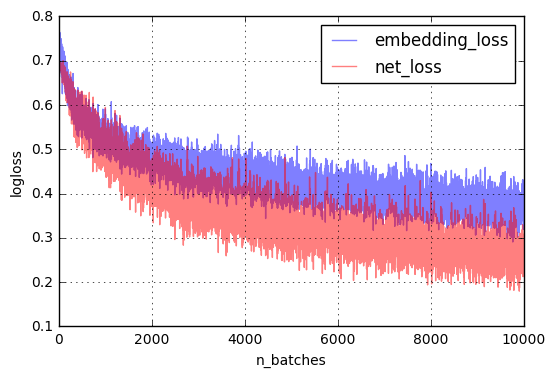

In [19]:
plot([x[0] for x in losses], c='b', label='embedding_loss', alpha=0.5)
plot([x[1] for x in losses], c='r', label='net_loss', alpha=0.5)
grid()
legend()
xlabel('n_batches')
ylabel('logloss')